# S06-demo-01 – Дерево решений (Decision Tree)

В этом демо-ноутбуке мы “пощупаем руками” **дерево решений** и разберёмся:

- как дерево строит разбиения (правила вида *если… то…*);
- почему дерево легко **переобучается**;
- какими гиперпараметрами контролировать сложность;
- как работает **cost-complexity pruning** (обрезка по CCP, `ccp_alpha`).

**Ключевая идея всего ноутбука:** дерево почти всегда умеет “выучить” обучающую выборку слишком хорошо – и наша задача научиться **замерять** это и **управлять сложностью**.


## Как работать с этим ноутбуком самостоятельно

Этот ноутбук устроен как последовательная история: **идея → запуск кода → интерпретация результата**.  
Чтобы получить максимум пользы, держите в голове три вопроса, которые будут повторяться в разных местах:

1) *Что делает модель на train и на test?* (обобщение vs подгонка)  
2) *Как меняется сложность дерева?* (глубина/листья/обрезка)  
3) *Как это отражается на границе решений и метриках?* (интерпретируемость и качество)

### Как читать результаты
- Если на **train** метрика заметно выше, чем на **test**, это обычно сигнал **переобучения**.  
- Дерево “любит” усложняться: без ограничений оно часто строит очень подробные правила, которые хорошо описывают обучение, но хуже работают на новых данных.
- Ограничения (`max_depth`, `min_samples_leaf`, `ccp_alpha`) – это способы **регуляризации**: мы уменьшаем гибкость модели, чтобы улучшить обобщение.

### Самопроверка по ходу
Иногда вы увидите блоки **Самопроверка**. Это не "вопросы преподавателя", а подсказки, что именно стоит осознанно заметить перед запуском следующей ячейки.


## 0. Импорты и вспомогательные функции

Ниже – стандартный набор для работы с деревом решений:

- **датасеты**: игрушечный `make_moons` (2D) и табличный `breast_cancer`;
- **модель**: `DecisionTreeClassifier`;
- **метрики**: `accuracy`, `F1` (и опционально `ROC-AUC` при наличии вероятностей);
- **визуализация**: граница решений на 2D и “картинка дерева” (`plot_tree`).

Важно: мы фиксируем `RANDOM_STATE`, чтобы результаты были воспроизводимыми при повторном запуске.


In [1]:
# Базовые библиотеки: численные массивы + графики
import numpy as np
import matplotlib.pyplot as plt

# Датасеты: игрушечный 2D и табличный “реальный” пример
from sklearn.datasets import make_moons, load_breast_cancer

# Разбиение на train/test и метрики качества
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Модель дерева + визуализация структуры и экспорт правил
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# “Быстрая интерпретация”: важность признаков через перемешивание (permutation importance)
from sklearn.inspection import permutation_importance

# Фиксируем случайность: так результаты на семинаре будут воспроизводимыми
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# Вспомогательные функции для демо:
# - print_metrics: компактно печатает метрики и confusion matrix
# - plot_decision_boundary_2d: рисует границу решений на 2D (для интуиции)

def print_metrics(y_true, y_pred, y_proba=None, title=None):
    # y_true, y_pred: истинные и предсказанные метки классов (например, 0/1)
    # y_proba: вероятность класса 1 (нужна, если хотим посчитать ROC-AUC)
    if title:
        print(title)
    # Accuracy – доля правильных ответов (хороша как “первая” метрика, но не всегда достаточно)
    acc = accuracy_score(y_true, y_pred)
    # F1 – баланс precision/recall (часто полезнее accuracy при дисбалансе классов)
    f1 = f1_score(y_true, y_pred)
    print(f"accuracy = {acc:.4f}")
    print(f"f1       = {f1:.4f}")
    if y_proba is not None:
        # ROC-AUC корректно считать по вероятностям/скорингам, а не по “жёстким” классам
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"roc_auc  = {auc:.4f}")
        except Exception:
            # Иногда AUC может не считаться (например, если в y_true один класс)
            pass
    print("confusion_matrix:")
    print(confusion_matrix(y_true, y_pred))
    print()


def plot_decision_boundary_2d(model, X, y, title=None, steps=300):
    # Работает только для 2D признаков (чисто для визуального понимания)
    # Идея: строим сетку точек, предсказываем класс в каждой – получаем “карту” решений
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps),
                         np.linspace(y_min, y_max, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, zz, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
    if title:
        plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()


## 1. Интуиция на 2D-датасете

Начнём с игрушечного датасета `make_moons` (две “луны”). Он хорош тем, что:

- признаков всего два → можно рисовать **границы решений**;
- разделение классов нелинейное → линейным моделям сложно, деревьям обычно проще.

**Самопроверка:** если дереву "разрешить всё", где качество будет выше – на *train* или на *test*? Почему?


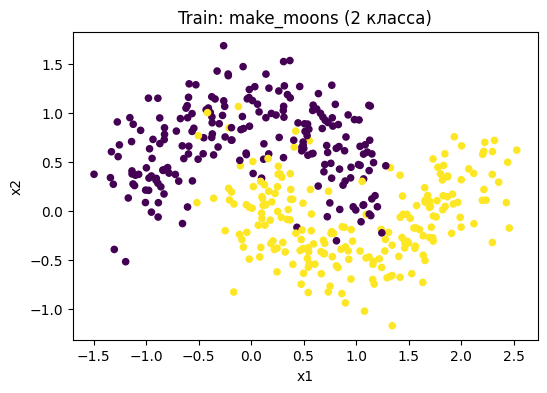

In [3]:
# Генерируем игрушечный датасет “две луны”.
# noise добавляет шум (это важно: на шуме переобучение видно особенно хорошо).
X, y = make_moons(n_samples=600, noise=0.25, random_state=RANDOM_STATE)

# Разбиваем на train/test.
# stratify=y сохраняет доли классов в обеих выборках (хорошая привычка для классификации).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

# Посмотрим на обучающую выборку – в 2D её легко визуализировать.
plt.figure(figsize=(6, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20)
plt.title("Train: make_moons (2 класса)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


### 1.1. Обучаем “полное” дерево

Если не ограничивать сложность (`max_depth=None` по умолчанию), дерево будет пытаться максимально хорошо “объяснить” обучающую выборку.

Что это означает на практике:

- дерево добавляет всё новые разбиения, пока может улучшать критерий (Gini/entropy);
- на шумных данных граница решений становится “рваной”;
- качество на *train* часто становится очень высоким, а на *test* – хуже.

**Самопроверка:** ожидаете ли вы заметную разницу между train и test уже на этом игрушечном примере? От чего она зависит?


In [4]:
# Обучаем “полное” дерево (без явных ограничений сложности).
# Важно: у DecisionTreeClassifier по умолчанию max_depth=None → дерево растёт, пока может улучшать критерий.
tree_full = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_full.fit(X_train, y_train)

# Сравним качество на train и test – это базовый способ “поймать” переобучение.
y_pred_train = tree_full.predict(X_train)
y_pred_test = tree_full.predict(X_test)

print_metrics(y_train, y_pred_train, title="FULL TREE – train")
print_metrics(y_test, y_pred_test, title="FULL TREE – test")


FULL TREE – train
accuracy = 1.0000
f1       = 1.0000
confusion_matrix:
[[210   0]
 [  0 210]]

FULL TREE – test
accuracy = 0.8778
f1       = 0.8830
confusion_matrix:
[[75 15]
 [ 7 83]]



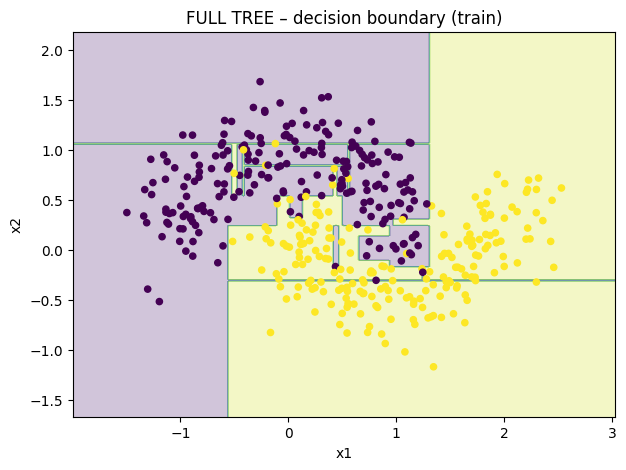

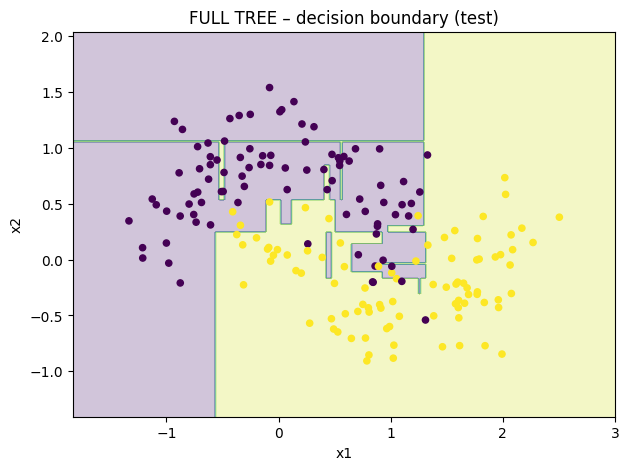

In [5]:
# Рисуем границы решений: на train и на test.
# Это помогает “увидеть” переобучение: слишком сложная граница часто означает подгонку под шум.
plot_decision_boundary_2d(tree_full, X_train, y_train, title="FULL TREE – decision boundary (train)")
plot_decision_boundary_2d(tree_full, X_test, y_test, title="FULL TREE – decision boundary (test)")


**Что важно заметить:** граница решений “рваная” и легко подстраивается под шум.

Это типичный симптом **высокой дисперсии** (*variance*): модель слишком чувствительна к конкретным объектам обучающей выборки.

Две полезные формулировки “в одно предложение” для студентов:
- *Переобучение* – когда модель “запоминает” обучение и хуже обобщает.
- *Регуляризация дерева* – это любые ограничения, которые **уменьшают число разбиений** или “сглаживают” листья.


### 1.2. Смотрим структуру дерева (визуально + правила)

У деревьев есть приятное свойство: их можно “читать” как набор правил.
Но полное дерево быстро разрастается, поэтому для визуализации мы ограничим глубину.

**Как читать дерево:**
- в узле написано условие вида `x_j <= threshold`;
- слева – ветка “условие истинно”, справа – “ложно”;
- в листьях – итоговый класс (и распределение по классам внутри листа).

Сравните структуру дерева и форму границы решений выше – это один и тот же механизм, просто в разных представлениях.


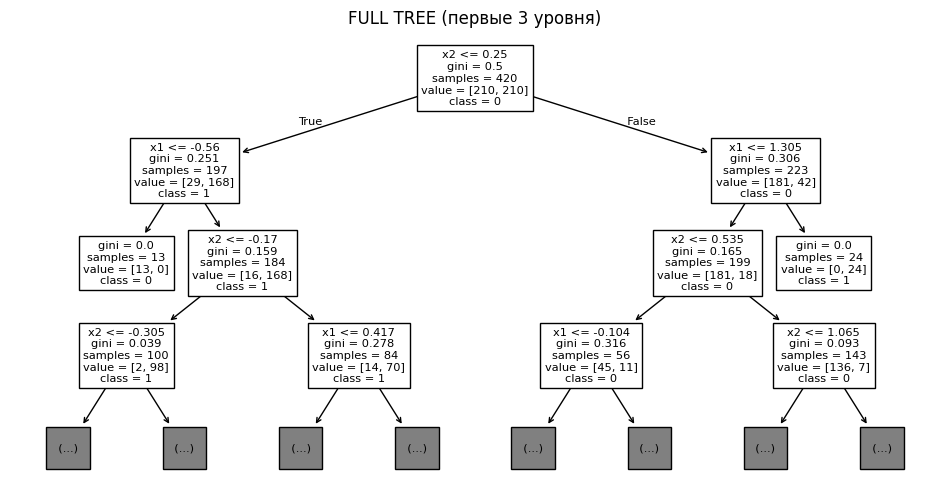

In [6]:
# Визуализируем первые уровни дерева (полностью дерево может быть слишком большим).
# max_depth здесь ограничивает только визуализацию, а не само обученное дерево.
plt.figure(figsize=(12, 6))
plot_tree(tree_full, max_depth=3, filled=False, feature_names=["x1", "x2"], class_names=["0", "1"])
plt.title("FULL TREE (первые 3 уровня)")
plt.show()


In [7]:
# Экспортируем дерево в текстовый вид правил.
# Это удобный способ “прочитать” модель: сверху вниз по веткам.
rules = export_text(tree_full, feature_names=["x1", "x2"], max_depth=3)
print(rules)


|--- x2 <= 0.25
|   |--- x1 <= -0.56
|   |   |--- class: 0
|   |--- x1 >  -0.56
|   |   |--- x2 <= -0.17
|   |   |   |--- x2 <= -0.31
|   |   |   |   |--- class: 1
|   |   |   |--- x2 >  -0.31
|   |   |   |   |--- truncated branch of depth 4
|   |   |--- x2 >  -0.17
|   |   |   |--- x1 <= 0.42
|   |   |   |   |--- class: 1
|   |   |   |--- x1 >  0.42
|   |   |   |   |--- truncated branch of depth 7
|--- x2 >  0.25
|   |--- x1 <= 1.31
|   |   |--- x2 <= 0.54
|   |   |   |--- x1 <= -0.10
|   |   |   |   |--- class: 0
|   |   |   |--- x1 >  -0.10
|   |   |   |   |--- truncated branch of depth 5
|   |   |--- x2 >  0.54
|   |   |   |--- x2 <= 1.06
|   |   |   |   |--- truncated branch of depth 11
|   |   |   |--- x2 >  1.06
|   |   |   |   |--- class: 0
|   |--- x1 >  1.31
|   |   |--- class: 1



## 2. Как дерево переобучается

Проверим эффект глубины: чем глубже дерево – тем легче оно “запоминает” тренировочные данные.

**Гипотеза перед запуском:**  
- train-качество будет расти почти монотонно;  
- test-качество сначала вырастет (модель “учится”), а потом начнёт падать (модель “переучилась”).


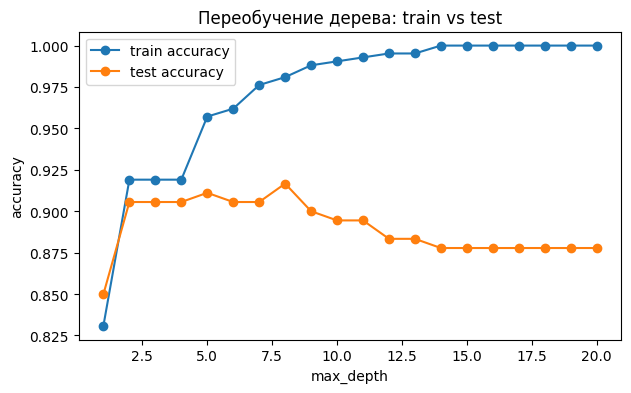

In [8]:
# Проверяем влияние глубины на переобучение.
# Идея: обучаем много деревьев с разной max_depth и сравниваем accuracy на train/test.
depths = list(range(1, 21))
train_acc = []
test_acc = []

for d in depths:
    m = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)
    m.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, m.predict(X_train)))
    test_acc.append(accuracy_score(y_test, m.predict(X_test)))

# График “классика”: train растёт, test обычно имеет максимум и затем падает.
plt.figure(figsize=(7, 4))
plt.plot(depths, train_acc, marker="o", label="train accuracy")
plt.plot(depths, test_acc, marker="o", label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Переобучение дерева: train vs test")
plt.legend()
plt.show()


Обычно видно типичную картину:

- train-качество растёт почти монотонно;
- test-качество растёт до некоторой точки, затем падает → **переобучение**.

**Самопроверка:** где находится "разумная" глубина по графику?  
Идея здесь простая: мы выбираем гиперпараметр не по train, а по тому, как модель ведёт себя на данных, которые она **не видела**.


## 3. Контроль сложности: `max_depth`, `min_samples_leaf`

Попробуем “успокоить” дерево:

- ограничим глубину (`max_depth`);
- потребуем минимум объектов в листе (`min_samples_leaf`).

Интуиция:
- `max_depth` ограничивает **сколько раз** мы можем последовательно “дробить” пространство;
- `min_samples_leaf` запрещает листья, которые объясняют **слишком мало** объектов (часто это и есть “подгонка под шум”).


REGULARIZED TREE – train
accuracy = 0.9524
f1       = 0.9512
confusion_matrix:
[[205   5]
 [ 15 195]]

REGULARIZED TREE – test
accuracy = 0.9222
f1       = 0.9213
confusion_matrix:
[[84  6]
 [ 8 82]]



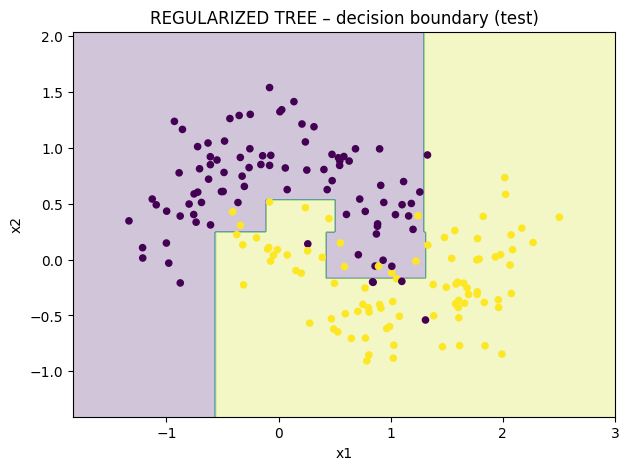

In [9]:
# “Успокаиваем” дерево регуляризацией.
# max_depth ограничивает количество последовательных разбиений,
# min_samples_leaf запрещает слишком маленькие листья (часто это и есть “подгонка под шум”).
tree_reg = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=10,
    random_state=RANDOM_STATE
)
tree_reg.fit(X_train, y_train)

print_metrics(y_train, tree_reg.predict(X_train), title="REGULARIZED TREE – train")
print_metrics(y_test, tree_reg.predict(X_test), title="REGULARIZED TREE – test")

# Граница решений должна стать менее “рваной” по сравнению с полным деревом.
plot_decision_boundary_2d(tree_reg, X_test, y_test, title="REGULARIZED TREE – decision boundary (test)")


Смысл простой: мы **уменьшаем гибкость** модели, чтобы она меньше “учила шум” и лучше обобщала.

**Самопроверка:** что должно произойти с границей решений после регуляризации – станет более гладкой или ещё более рваной?  
Свяжите ответ с тем, что именно делает ограничение сложности (оно уменьшает число “свобод” у модели).


## 4. Cost-Complexity Pruning (CCP): `ccp_alpha`

`scikit-learn` умеет строить “путь обрезки” для уже обученного дерева и предлагать значения `ccp_alpha`.

Интуиция CCP:
- у дерева есть “стоимость сложности” (сколько узлов/листьев);
- `ccp_alpha` задаёт штраф за сложность;
- чем больше `ccp_alpha`, тем сильнее дерево **обрезается** (становится меньше).

На практике мы строим несколько деревьев вдоль пути обрезки и выбираем компромисс **качество / простота** по *test* (или по валидации).


In [10]:
# CCP pruning: строим путь обрезки для уже обученного дерева.
# cost_complexity_pruning_path возвращает набор возможных alpha и соответствующие “эффективные” примеси (impurities).
path = tree_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Чтобы не плодить десятки почти одинаковых моделей:
# берём уникальные alpha и слегка прорежаем, если их слишком много.
ccp_alphas = np.unique(ccp_alphas)
if len(ccp_alphas) > 60:
    ccp_alphas = ccp_alphas[:: max(1, len(ccp_alphas)//60)]

train_scores = []
test_scores = []
node_counts = []

models = []
for a in ccp_alphas:
    # Чем больше ccp_alpha → тем сильнее обрезка (дерево меньше).
    m = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=float(a))
    m.fit(X_train, y_train)
    models.append(m)
    train_scores.append(accuracy_score(y_train, m.predict(X_train)))
    test_scores.append(accuracy_score(y_test, m.predict(X_test)))
    node_counts.append(m.tree_.node_count)

# Выбираем alpha по качеству на test (в реальном проекте обычно используют валидацию/CV).
best_idx = int(np.argmax(test_scores))
best_alpha = float(ccp_alphas[best_idx])
best_model = models[best_idx]

best_alpha, test_scores[best_idx], node_counts[best_idx]


(0.0026418026418026422, 0.9277777777777778, 35)

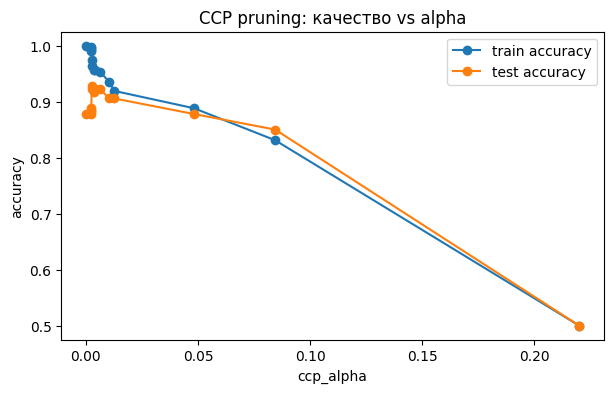

In [11]:
# Смотрим, как меняется качество при росте alpha (обрезке).
plt.figure(figsize=(7, 4))
plt.plot(ccp_alphas, train_scores, marker="o", label="train accuracy")
plt.plot(ccp_alphas, test_scores, marker="o", label="test accuracy")
plt.xlabel("ccp_alpha")
plt.ylabel("accuracy")
plt.title("CCP pruning: качество vs alpha")
plt.legend()
plt.show()


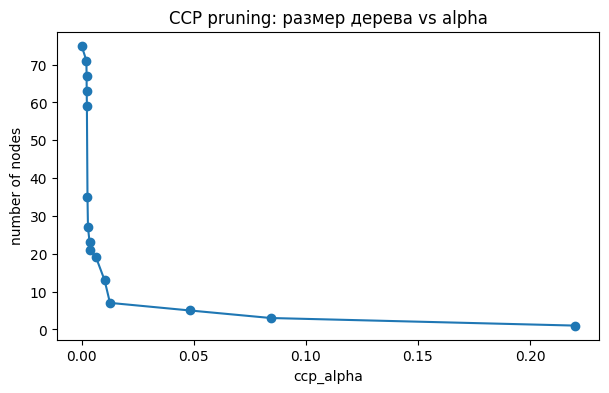

In [12]:
# И отдельно – как уменьшается размер дерева (число узлов) при росте alpha.
plt.figure(figsize=(7, 4))
plt.plot(ccp_alphas, node_counts, marker="o")
plt.xlabel("ccp_alpha")
plt.ylabel("number of nodes")
plt.title("CCP pruning: размер дерева vs alpha")
plt.show()


Лучшее alpha по test accuracy: 0.0026418026418026422
BEST CCP TREE – test
accuracy = 0.9278
f1       = 0.9282
confusion_matrix:
[[83  7]
 [ 6 84]]



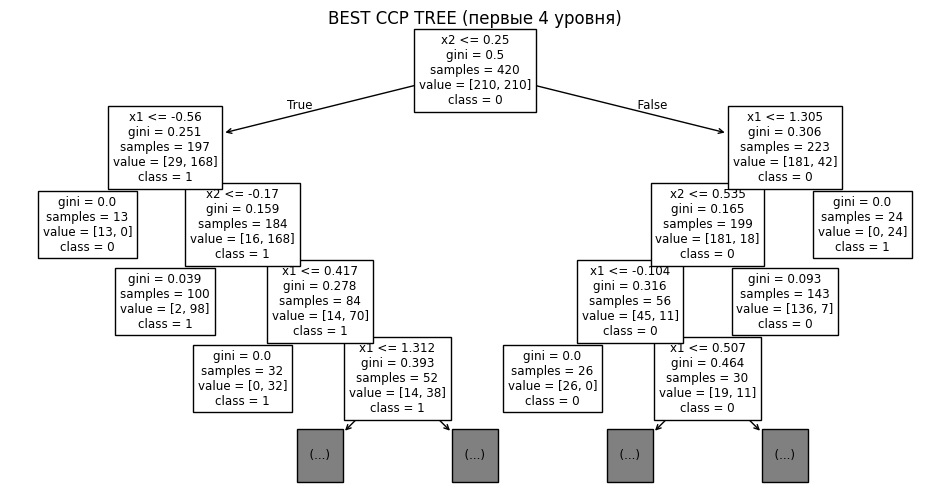

In [13]:
# Фиксируем лучший alpha и смотрим итоговое качество.
print(f"Лучшее alpha по test accuracy: {best_alpha}")
print_metrics(y_test, best_model.predict(X_test), title="BEST CCP TREE – test")

# И визуализируем “обрезанное” дерево (первые уровни).
plt.figure(figsize=(12, 6))
plot_tree(best_model, max_depth=4, filled=False, feature_names=["x1", "x2"], class_names=["0", "1"])
plt.title("BEST CCP TREE (первые 4 уровня)")
plt.show()


## 5. Мини-практика на “реальном” табличном датасете

Теперь возьмём `breast_cancer` из `sklearn.datasets`: много признаков, бинарная классификация.

Здесь уже сложнее “рисовать” границы решений, зато удобно:

- смотреть метрики качества (включая ROC-AUC, если есть вероятности);
- быстро оценить **важность признаков** (permutation importance).

Важно: это демонстрация на hold-out split. Для серьёзных выводов нужен хотя бы CV.


In [14]:
# Переходим к табличному датасету breast_cancer (бинарная классификация).
data = load_breast_cancer()
X = data["data"]
y = data["target"]
feature_names = list(data["feature_names"])

# Hold-out split (демо-режим).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# Для табличных данных сразу используем регуляризованное дерево (как более “здравый” baseline).
tree = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=5,
    min_samples_leaf=10
)
tree.fit(X_train, y_train)

# Для ROC-AUC нам нужны вероятности.
proba_test = tree.predict_proba(X_test)[:, 1]
# Для метрик по классам (accuracy/F1) берём стандартный порог 0.5.
pred_test = (proba_test >= 0.5).astype(int)

print_metrics(y_test, pred_test, y_proba=proba_test, title="Breast cancer – DecisionTree")


Breast cancer – DecisionTree
accuracy = 0.9510
f1       = 0.9613
roc_auc  = 0.9828
confusion_matrix:
[[49  4]
 [ 3 87]]



### 5.1. Быстрая интерпретация: permutation importance

Permutation importance показывает, насколько падает качество, если **случайно перемешать** значения одного признака (ломаем связь признака с целевой переменной).

Это не SHAP и не "полная причинность", но как быстрый инженерный инструмент очень полезно:

- помогает понять, какие признаки *реально* двигают качество;
- позволяет быстро найти “пустые” признаки;
- хорошо работает как baseline-интерпретация, даже если дальше вы перейдёте к ансамблям.


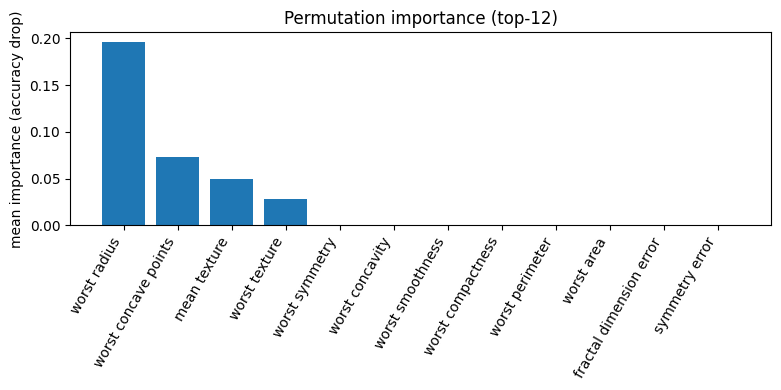

In [15]:
# Permutation importance: по очереди перемешиваем один признак и смотрим, насколько падает качество.
# Чем сильнее падение – тем более “важен” признак для данной модели и данного набора данных.
perm = permutation_importance(
    tree, X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="accuracy"
)

importances = perm.importances_mean
# Сортируем признаки по важности (убывание) и возьмём top-12 для наглядного графика.
idx = np.argsort(importances)[::-1][:12]

plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel("mean importance (accuracy drop)")
plt.title("Permutation importance (top-12)")
plt.tight_layout()
plt.show()


## 6. Выводы (коротко)

- Дерево – понятная модель правил, хорошо ловит нелинейности.
- Но “полное” дерево почти всегда переобучается (train↑, test↓).
- Сложность контролируется: `max_depth`, `min_samples_leaf`, `ccp_alpha`.
- В реальных задачах дерево часто выступает **базовым блоком** для ансамблей (RandomForest / Gradient Boosting).

### Куда двигаться дальше
Если вы уверенно понимаете, **почему** и **как** дерево переобучается и чем отличается ограничение глубины от pruning, то логичный следующий шаг – посмотреть, как множество деревьев стабилизирует качество:

- **RandomForest**: “усредняем” много деревьев → снижаем variance.
- **Gradient Boosting**: строим деревья последовательно, исправляя ошибки → часто получаем более высокое качество.

